##Propagation through beamline with several optic elements

This example uses wave optics software based on SRW core library <https://github.com/ochubar/SRW>, available through WPG interactive framework <https://github.com/samoylv/WPG> 

#TODO
more short explaination about example


In [141]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


####Import modules and necessary core and helper functions

In [142]:
import os
import sys
#sys.path.insert(0,'/home/meyerann/WPG')
sys.path.insert(0,os.path.join('..','..'))

import time
import copy
import numpy
import pylab

#Base wavefront class
from wpg import Wavefront

#import SRW helpers functions
from wpg.useful_code.srwutils import AuxTransmAddSurfHeightProfileScaled

from wpg.srwlib import srwl, SRWLOptD, SRWLOptL, SRWLOptC, SRWLOptA, SRWLOptMirEl, SRWLOptT
#Gaussian beam generator
from wpg.generators import build_gauss_wavefront_xy
from wpg.beamline import Beamline
from wpg import optical_elements  # wrapers for optical elements
 
#helper functions
#from wfrutilsAKM import plot_wfront
from wpg.useful_code.wfrutils import plot_wfront, get_mesh, print_beamline, calculate_fwhm_x, calculate_fwhm_y, plot_1d, plot_2d

pylab.ion()

In [143]:
def calculate_theta_fwhm_cdr(ekev,qnC):
    """
    Calculate angular divergence using formula from XFEL CDR2011
    
    :param ekev: Energy in keV
    :param qnC: e-bunch charge, [nC]
    :return: theta_fwhm [units?]
    """
    theta_fwhm = (17.2 - 6.4 * sqrt(qnC))*1e-6/ekev**0.85
    return theta_fwhm

In [144]:
def defineOPD(opTrErMirr, mdatafile, ncol, delim, Orient, theta, scale):
    """
    Define optical path difference (OPD) from mirror profile, i.e. ill the struct opTrErMirr
    
    :params mdatafile: an ascii file with mirror profile data
    :params ncol: number of columns in the file
    :params delim: delimiter between numbers in an row, can be space (' '), tab '\t', etc
    :params orient: mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :params theta: incidence angle
    :params scale: scaling factor for the mirror profile    
    """
    heightProfData = numpy.loadtxt(mdatafile).T
    AuxTransmAddSurfHeightProfileScaled(opTrErMirr, heightProfData, Orient, theta, scale)
    pylab.figure()
    plot_1d(heightProfData,'profile from ' + mdatafile,'x (m)', 'h (m)')

In [145]:
def defineEFM(orient,p,q,thetaEFM,theta0,lengthEFM):
    """
    A wrapper to a SRWL function SRWLOptMirEl() for defining a plane elliptical focusing mirror propagator
    
    :param Orient:    mirror orientation, 'x' (horizontal) or 'y' (vertical)
    :param p:  the distance to two ellipsis centers
    :param q:  the distance to two ellipsis centers
    :param thetaEFM:  the design incidence angle in the center of the mirror
    :param theta0:    the "real" incidence angle in the center of the mirror
    :param lengthEFM: mirror length, [m]
    :return: the struct opEFM
    """
    if orient == 'x':     #horizontal plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=cos(theta0), _nvy=0, _nvz=-sin(theta0), _tvx=-sin(theta0), _tvy=0, _x=0, _y=0, _treat_in_out=1) 
    elif orient == 'y': #vertical plane ellipsoidal mirror
        opEFM = SRWLOptMirEl(_p=p, _q=q, _ang_graz=thetaEFM, _r_sag=1.e+40, _size_tang=lengthEFM, 
            _nvx=0, _nvy=cos(theta0), _nvz=-sin(theta0), _tvx=0, _tvy=-sin(theta0), _x=0, _y=0, _treat_in_out=1)
    else:
        raise TypeError('orient should be "x" or "y"')
    return opEFM

In [146]:
def defineBladeBL(width,zCenter,zEnd,orient='x',kFresnel=1,sizeX=5e-2,sizeY=5e-2):
    """
    A wrapper to a SRWL function SRWLOptA() for defining a beamline with a slit with 2 rectangular obstacles and 
    calculates expected position of k. minima of interference fringe caused by 1. and 2. obstacle.
    
    :param width:  slit width [m]
    :param zCenter:  position of center of blades [m]
    :param zEnd:  observation point position [m]
    :param orient: direction of shifting the slit center, 'x' (horizontal = default) or 'y' (vertical)
    :param kFresnel:  number of minimum on Fresnel diffraction curve, which position will be printed out
    :param sizeX: horizontal size of blade [m]
    :param sizeY: vertical size of blade [m]
    :return: the struct BL and parameter distanceBetweenObstacles
    """
    distBetweenObstacles = 0.30
    Position2Obstacle = zCenter+distBetweenObstacles/2
    distDriftAfter1Obstacle = zEnd - Position2Obstacle + distBetweenObstacles
    distDriftAfter2Obstacle = zEnd - Position2Obstacle

    F = width**2/(distDriftAfter1Obstacle*lamda)
    print 'Fresnel number after 1. obstacle in distacne %.3f m is %.3f' %(distDriftAfter1Obstacle, F)
    x_n = sqrt((distDriftAfter1Obstacle)*lamda*(2*kFresnel-1/4))
    print 'expected %f minima of interference fringe after 1. obstacle at: %.9f m' %(kFresnel,x_n)

    F = width**2/(distDriftAfter2Obstacle*lamda)
    print 'Fresnel number after 2. obstacle in distacne %.3f m is %.3f' %(distDriftAfter2Obstacle, F)
    x_n = sqrt((distDriftAfter2Obstacle/2)*lamda*(2*kFresnel-1/4))
    print 'expected %f minima of interference fringe after 2. obstacle at: %.9f m' %(kFresnel,x_n)


    if orient == 'x':
        opOpstacle1 = SRWLOptA('r', 'o',sizeX,sizeY,   (sizeX/2 + width/2),0)
        opOpstacle2 = SRWLOptA('r', 'o',sizeX,sizeY,  -(sizeX/2 + width/2),0)
    elif orient == 'y':
        opOpstacle1 = SRWLOptA('r', 'o',sizeX,sizeY,0, (sizeY/2 + width/2))
        opOpstacle2 = SRWLOptA('r', 'o',sizeX,sizeY,0,-(sizeY/2 + width/2))
    else:
        raise TypeError('orient should be "x" or "y"')
    
    DriftOp2Op = SRWLOptD(distBetweenObstacles)
    DriftAfter2Obstacle = SRWLOptD(distDriftAfter2Obstacle)
    
    L0 = Beamline()
    L1 = Beamline()
    L2 = Beamline()
    L0.append(opOpstacle1,    optical_elements.Use_PP(zoom_h=1.0, sampling_h=1.0/0.25, semi_analytical_treatment=0))
    #L.append(opOpstacle1,    optical_elements.Use_PP(zoom_h=0.2, sampling_h=1.0/0.3, semi_analytical_treatment=0))
    L1.append(DriftOp2Op,     optical_elements.Use_PP(semi_analytical_treatment=0))
    #L1.append(opOpstacle2,    optical_elements.Use_PP(zoom_h=0.5, sampling_h=1.0/0.5,  semi_analytical_treatment=0))
    L1.append(opOpstacle2,    optical_elements.Use_PP(zoom_h=1/2.5, sampling_h=1.0/0.5,  semi_analytical_treatment=0))
    #3L.append(opOpstacle2,    optical_elements.Use_PP(zoom_h=0.4, sampling_h=1.0/0.4,  semi_analytical_treatment=0))
    L2.append(DriftAfter2Obstacle, optical_elements.Use_PP(zoom_h=2.4, sampling_h=1.0/0.4,semi_analytical_treatment=1))    
        
    return L0,L1,L2, distBetweenObstacles

###  Gaussian wavefront parameters

Before building initial gaussian wavefront the beam parameters, which defines the behavior and geometry of a Gaussian beam, must be calculated. 

wave length of beam: $\lambda=\frac{12.4}{E[kev]}$ 

angular divergence: $\theta_{FWHM}$ is calculated by using the empirical formula from XFEL CDR2011

beam waist: $\omega_0 = \frac{\lambda}{\pi\theta}$

Rayleigh range: ${z}_R=\frac{\pi{\omega_0}^2}{\lambda}$  At this point the beam is widened to $\sqrt{2}\omega_0$

FWHM at ${z}_R$: $FWHM_{z_R} = \theta_{FWHM}{z}_R$ --> weil sin(theta[theta im bogenmass])=x\laenge=theta

FWHM of amplitude: $\frac{1}{2} = exp(-\frac{x^2}{w^2})$ --> $x = w\sqrt{-ln\frac{1}{2}}$ --> $x = 2\sigma\sqrt{ln2}$

$\sigma$ of amplitude: $ \sigma_{amp} = \frac{FWHM}{2\sqrt{ln2}} $

Expected FWHM at first screen or focusing mirror: $FWHM_{d} = \theta_{FWHM}d$

Afterwards the parameters will be printed out, so the expected FWHM can be compared with the propagated.

In [147]:
#wavefront parameters
qnC = 0.1  # e-bunch charge, [nC]
pulse_duration = 9.e-15 # [s]      
#ekev = 0.8  # Energy in [keV]
ekev = 0.4
d2HEFM = 284.0 #distance to M2
#d2HEFM = 373.85

lamda = 12.4*1e-10/ekev # wavelength [AKM]
theta_fwhm = calculate_theta_fwhm_cdr(ekev,qnC)#angular divergence
w0 = lamda/(pi*theta_fwhm) # beam waist
z_R = (pi*w0**2)/lamda #Rayleigh range
fwhmAtZ_R = theta_fwhm*z_R #FWHM at Rayleigh range
sigmaAmp = w0/(2*sqrt(log(2))) #sigma of amplitude


#Print out the calculated wavefront parameters and expected FWHM
print 'theta_fwhm: %.2f urad' % (theta_fwhm*1e6)
print 'w0 %.3f um:' %(w0*1e6)
print 'lamda %.3f nm:' %(lamda*1e9)
print '2*z_R: %.3f m:' %(2*z_R)
print 'sigma_Amplitude %.3f um:' %(sigmaAmp*1e6)
#print 'expected FWHM at distance Rayleigh length %.1f nm: %.2f um' %(z_R,fwhmAtZ_R*1e6)
print 'expected FWHM at distance %.1f: %.2f mm' %(d2HEFM,theta_fwhm*d2HEFM*1e3)

theta_fwhm: 33.07 urad
w0 29.840 um:
lamda 3.100 nm:
2*z_R: 1.805 m:
sigma_Amplitude 17.921 um:
expected FWHM at distance 284.0: 9.39 mm


### initial Gaussian wavefront
With the calculated beam parameters the initial wavefront is build with 400x400 data points and in distance of the first horizontal elliptical focusing mirror (M2) at 284m. For further propagation the built wavefront should be stored. After plotting the wavefront the FWHM should be printed out for comparing.

####gaussian beam radius and size at some point 
$\omega(z) = \omega_0*\sqrt{1+(\frac{z\lambda}{\pi\omega_0^2})^2}$ 

$\frac{1}{z_R} = \frac{\lambda}{\pi\omega_0^2}$

$\omega(z) = \omega_0*\sqrt{1+(\frac{z}{z_R})^2}$

####beam size is a little bit (ca 200 nm )smaller than expected. Is it because the calculating of the expected FWHM is approximatly???

beam radius at several point
$\omega(z) = \omega_0*\sqrt{1+(\frac{z\lambda}{\pi\omega_0^2})^2}$ 

$\frac{1}{z_R} = \frac{\lambda}{\pi\omega_0^2}$

$\omega(z) = \omega_0*\sqrt{1+(\frac{z}{z_R})^2}$



range_xy : 0.0469570639265
saving WF to data_common/gwf.h5
FWHMx [mm]: 9.06188952968
FWHMy [mm]: 9.06188952968
Coordinates of center, [mm]: 0.0588434385044 0.0588434385044
stepX, stepY [um]: 117.686877009 117.686877009 

 
 FWHM at distance 284.0: 9.062 mm


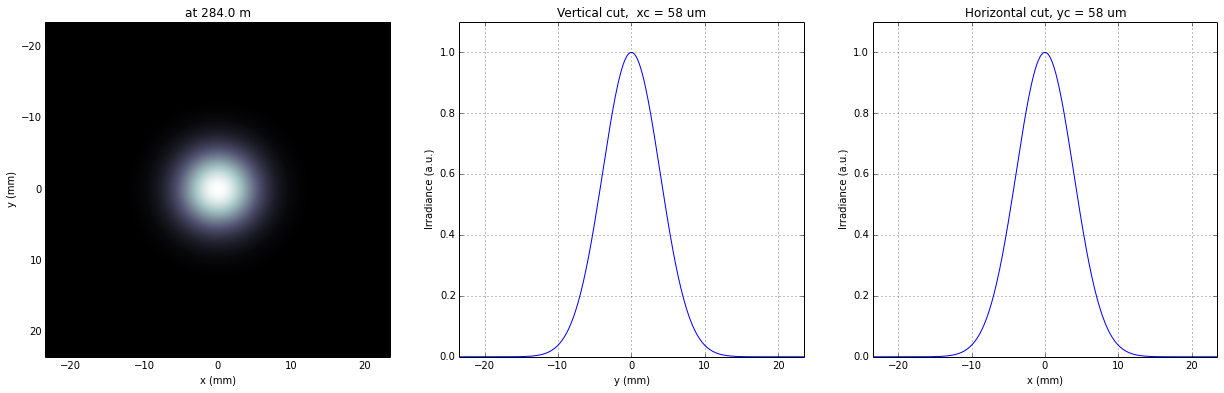

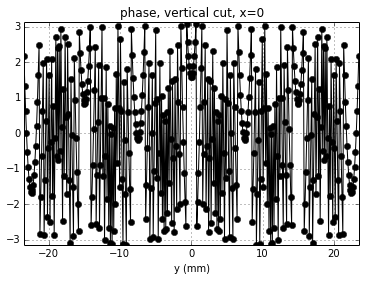

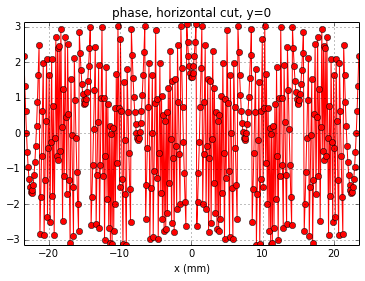

In [148]:
#number of points
np = 400

#quintuple beam radius at horizontal lens distance to get the range of the wavefront 
range_xy = w0*sqrt(1+(d2HEFM/z_R)**2) *5
print 'range_xy :', range_xy

#build wavefront
wfr = build_gauss_wavefront_xy(nx=np, ny=np, ekev=ekev, xMin=-range_xy/2, xMax=range_xy/2, 
                               yMin=-range_xy/2, yMax=range_xy/2, sigX=sigmaAmp, 
                               sigY=sigmaAmp,d2waist=d2HEFM)
#init WPG Wavefront with helper class
mwf = Wavefront(wfr)

#defining name HDF5 file for storing wavefront
strOutInDataFolder = 'data_common'
wfr0Name = os.path.join(strOutInDataFolder,'gwf'+'.h5')
#store wavefront to HDF5 file 
mwf.store_hdf5(wfr0Name)
print 'saving WF to %s' %wfr0Name

#plot the wavefront
plot_wfront(mwf, title_fig='at '+str(d2HEFM)+' m', isHlog=False, isVlog=False,
            i_x_min=1e-6, i_y_min=1e-6, orient='y', onePlot=True, bPlotPha=True)
print ' '
print ' FWHM at distance %.1f: %.3f mm' %(d2HEFM,calculate_fwhm_x(mwf)*1e3)

###Horizontal elliptical focusing offset mirror (M2):

The wavefront will be focused with a focusing offset mirror (M2) at distance (284.0m) in horizon plane. Before focusing the beam the expected beam size after the propagation at point of focus and calculating distances of focus.

Focal length for thin lenses will be calculated by

$\frac{1}{f}=\frac{1}{p}+\frac{1}{q}$

The expected FWHM at focus will be calculated with proportion of the distances after and before the lens multiplied by the FWHM at source 

$FWHM_{focus}=\frac{q}{p}*FWHM_{source}$

In [149]:
horFocus = 374.0 #given point of where the focus should be
q = horFocus-d2HEFM # distance between horizontal focusing lens and given point of focus
d2horizontalFocus =1./(1./d2HEFM + 1./q) #calculating horizontal focal length

FWHM_1HFocus = q/d2HEFM*fwhmAtZ_R #calculating expected FWHM of beam at focus
print 'p, q: %.1f, %.1f m' %(d2HEFM, q)
print 'M2 focal length: %.1f m' %(d2horizontalFocus)
print 'expected horizontal FWHM in focus (at distance %.1f m): %.2f um' %(horFocus,FWHM_1HFocus*1e6)


p, q: 284.0, 90.0 m
M2 focal length: 68.3 m
expected horizontal FWHM in focus (at distance 374.0 m): 9.46 um


### Building beamline with focusing mirror
The beamline consists of an aperture infront of the horizontal lens, to clean up the beam, the lens and the drift after lens to the focus. So the wavefront is propagated from first horizontal lens at 284m to given focus at 374m.

The size of the horizontal FWHM at horizontal focus varies according to the change of the angle of the offset focussing mirror. The beam gets a smaller focus with bigger angle. 
#####The length of the mirror is realized with the aperture.
The size of the aperture is calculated with angle and length of mirror $l_M$
$sin\theta = \frac{x}{l_M}$ --> $x = sin\theta*l_M$ with $sin\theta = \theta$ for small angles in urad.
##### The aperture a different incidence angle as the mirror, because ....
##### When incidence angle is 6 mrad, the aperture size is ..., the focus (FWHM)   is about 19.6um for 0.8 keV
##### when  incidence angle is 20 mrad, the aperture size is ...,  the focus (FWHM)   is about 9.6um. 
##### The expected 'geometrical' FWHM is 8.52um. 
### Why (see diffraction at aperture)?



Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 1.0, 8.0, 1.0, 1.0, 0, 0, 0]
	Dx = 0.0048
	Dy = 0.0469570639265
	ap_or_ob = a
	shape = r
	x = 0
	y = 0
	
Optical Element: Mirror: Ellipsoid
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	Fx = 0
	Fy = 0
	angGraz = 0.0524
	apShape = r
	arRefl = array of size 2
	ds = 1
	dt = 0.5
	extIn = 0
	extOut = 0
	meth = 2
	nps = 500
	npt = 500
	nvx = 0.998627434104
	nvy = 0
	nvz = -0.0523760236546
	p = 284.0
	q = 90.0
	radSag = 1e+40
	reflAngFin = 0
	reflAngScaleType = lin
	reflAngStart = 0
	reflNumAng = 1
	reflNumComp = 1
	reflNumPhEn = 1
	reflPhEnFin = 1000.0
	reflPhEnScaleType = lin
	reflPhEnStart = 1000.0
	treatInOut = 1
	tvx = -0.0523760236546
	tvy = 0
	x = 0
	y = 0
	
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 1.0, 1.0, 1.0, 1.0, 0, 0, 0]
	L = 90.0
	treat = 0
	
Optical Element: Aperture / Obstacle
Prop. parameters = [0, 0, 1.0, 0, 0, 0.06666666666666667, 1.0, 1.0, 1.0, 0, 0, 0]
	

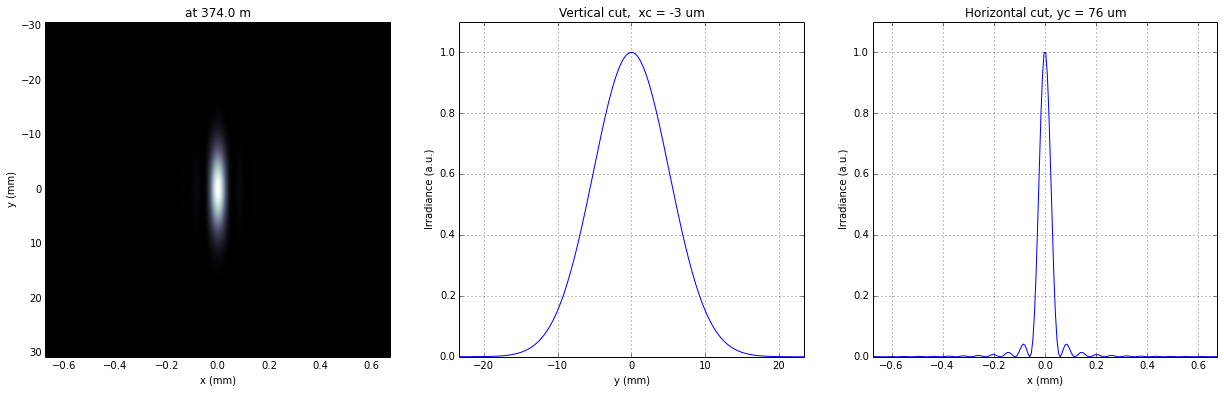

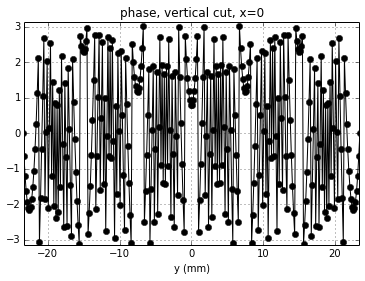

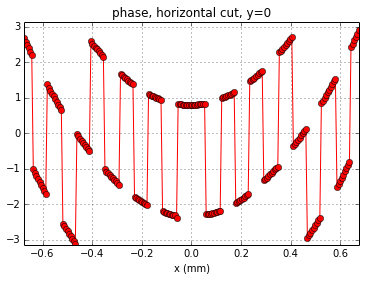

In [150]:
#horizontal apterure size
#thetaOM = 3.5e-3 
#thetaOM = 21e-3  ##<-- is near by the expected FWHM at horizontal focus
thetaOM = 6e-3 
horApM1 = 0.8*thetaOM
opApHEFM =  SRWLOptA('r', 'a',horApM1,range_xy) 
opApGen=SRWLOptA('r', 'a',range_xy,range_xy) 


thetaEM = 52.4e-3   # incidence angle of elliptical  mirror, 3 deg
lengthM = 0.5 #[m]
HorizontalEFM = defineEFM(orient='x',p=d2HEFM ,q=q,thetaEFM=thetaEM,theta0=thetaEM,
                          lengthEFM=lengthM)
DriftHEFM_Focus = SRWLOptD(q)

BL0 = Beamline()
BL0.append(opApHEFM,       optical_elements.Use_PP(sampling_h=1.0/0.125, semi_analytical_treatment=0))
BL0.append(HorizontalEFM,  optical_elements.Use_PP(semi_analytical_treatment=1))
BL0.append(DriftHEFM_Focus,optical_elements.Use_PP(semi_analytical_treatment=1))
BL0.append(opApGen,optical_elements.Use_PP(zoom_h=1/15.))

print BL0


# reload the wavefront (good practise while debugging beamline)
mwf = Wavefront()
mwf.load_hdf5(wfr0Name)
print 'loading WF from %s' %wfr0Name

BL0.propagate(mwf)

print 'Plot mit obstacle'
plot_wfront(mwf, title_fig='at '+str(d2HEFM + q)+' m', isHlog=False, isVlog=False, 
            i_x_min=1e-3, i_y_min=1e-3, orient='x', onePlot=True, bPlotPha=True)
print ' '

## Beamline with a horizontal focussing mirror and two blades
Now the beamline consists an aperture infront of the focussing mirror, 2 obstacles and the drifts in between and drift to screen at 420m.

###Fresnel diffraction on edge (blade)

Beugungserscheinung an Kante treten auf. Hellere und dunklere Interferenzstreifen treten auf. Abstand zwischen den Streifen werden mit zunehmendem  Abstand laengst der Kante geringer. Abstand zwischen den dunkleren Interferenzstreifen laesst sich berechnen durch:

$x_n = \sqrt{L\lambda(n-\frac{1}{4})}$ ; n = 2,4,6,...
L ist Abstand Zwischen Beugungsobjekt und Beobachtungsebene

#####Fresnel number F: How much will the beam bend at an aperture 

$F=\frac{a^2}{d*\lambda}$

Fresnel diffraction is when $F \approx1 $

Fraunhofer diffraction is when $F \ll 1$

In [151]:
#TODO:insert Fresnel number plot here

In [152]:
slit_size = 20e-6
ScreenPosition = 420

BL2 = Beamline()
BL3 = Beamline()
BL4 = Beamline()
#define beamline with 1. blade on focus
BL2,BL3,BL4, distBetweenObstacles = defineBladeBL(width=slit_size, zCenter=horFocus-0.15, zEnd=ScreenPosition, orient='x', kFresnel=2)
DriftHM2Op = SRWLOptD(q)

BL1 = Beamline()
#BL1.append(opApHEFM,       optical_elements.Use_PP(sampling_h=1.0/0.2, semi_analytical_treatment=0))
BL1.append(opApHEFM,       optical_elements.Use_PP(sampling_h=1.0/0.125, semi_analytical_treatment=0))
BL1.append(HorizontalEFM,  optical_elements.Use_PP(semi_analytical_treatment=1))
BL1.append(DriftHM2Op,     optical_elements.Use_PP(semi_analytical_treatment=1)) 
BL1.append(opApGen,optical_elements.Use_PP(zoom_h=1/15.))

#print BL1
#print BL2
#print BL3
print BL4

Fresnel number after 1. obstacle in distacne 46.300 m is 0.003
expected 2.000000 minima of interference fringe after 1. obstacle at: 0.000757707 m
Fresnel number after 2. obstacle in distacne 46.000 m is 0.003
expected 2.000000 minima of interference fringe after 2. obstacle at: 0.000534041 m
Optical Element: Drift Space
Prop. parameters = [0, 0, 1.0, 1, 0, 2.4, 2.5, 1.0, 1.0, 0, 0, 0]
	L = 46.0
	treat = 0
	



loading WF from data_common/gwf.h5
loading WF from data_common/wBL1.h5
Plot before obstacle
FWHMx [mm]: 0.0439475855517
FWHMy [mm]: 11.8579961791
Coordinates of center, [mm]: -0.00313911325369 0.0769999751892
stepX, stepY [um]: 6.27822650739 153.999950378 

 


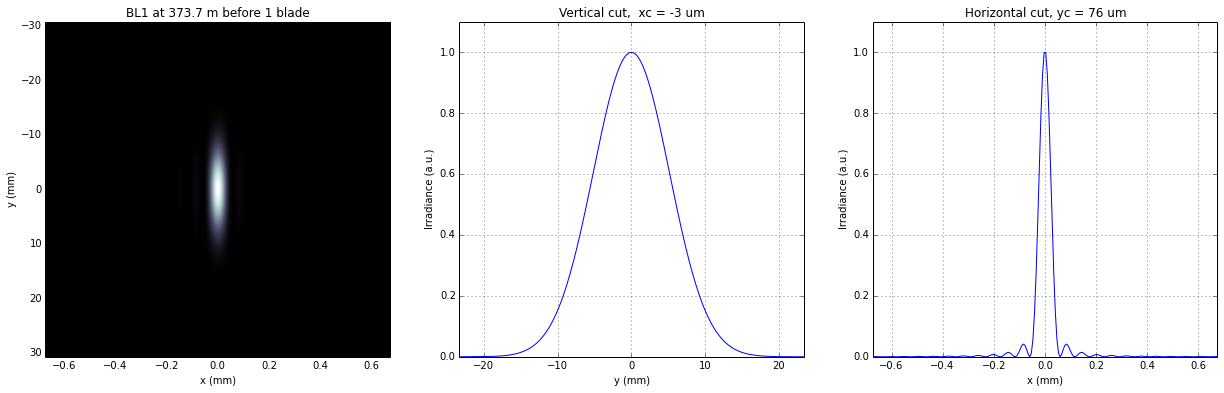

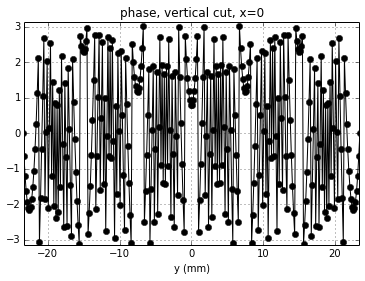

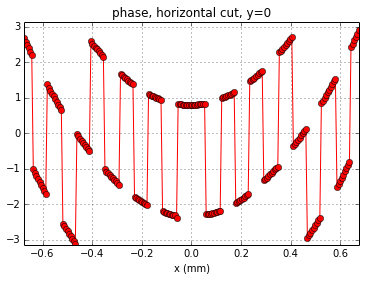

In [153]:
# reload the initial wavefront (good practise while debugging beamline)
wfr = Wavefront()
wfr.load_hdf5(wfr0Name)
print 'loading WF from %s' %wfr0Name

BL1.propagate(wfr) #propagates the beamline until the 1. blade

wfr1Name = os.path.join(strOutInDataFolder,'wBL1'+'.h5')
#store wavefront to HDF5 file 
wfr.store_hdf5(wfr1Name)
print 'loading WF from %s' %wfr1Name

print 'Plot before obstacle'
plot_wfront(wfr, title_fig='BL1 at '+str(horFocus-0.15-distBetweenObstacles/2)+' m before 1 blade', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '

loading WF from data_common/wBL1.h5
loading WF from data_common/wBL2.h5
Plot with obstacle
FWHMx [mm]: 0.0344102101737
FWHMy [mm]: 11.8579961791
Coordinates of center, [mm]: -0.000782050231221 0.0769999751892
stepX, stepY [um]: 1.56410046244 153.999950378 

 


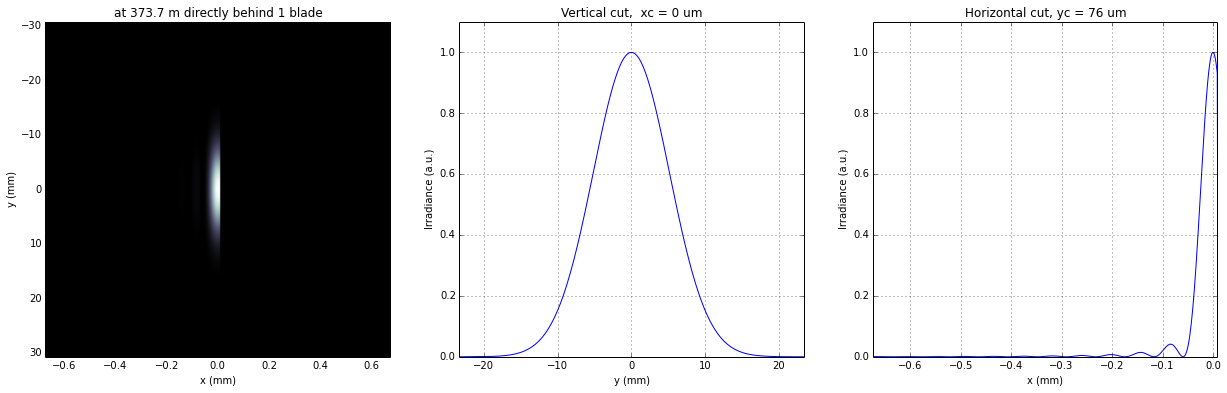

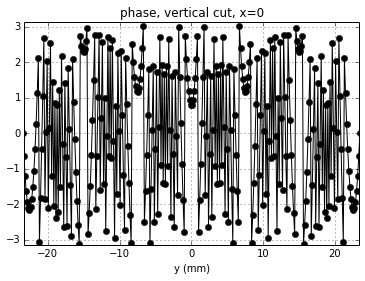

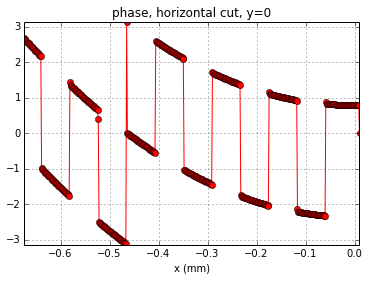

In [154]:

# reload the initial wavefront (good practise while debugging beamline)
wfr = Wavefront()
wfr.load_hdf5(wfr1Name)
print 'loading WF from %s' %wfr1Name

BL2.propagate(wfr) #propagates the beamline from 1.blade until screen

wfr2Name = os.path.join(strOutInDataFolder,'wBL2'+'.h5')
#store wavefront to HDF5 file 
wfr.store_hdf5(wfr2Name)
print 'loading WF from %s' %wfr2Name

print 'Plot with obstacle'
plot_wfront(wfr, title_fig='at '+str(horFocus-0.15-distBetweenObstacles/2)+' m directly behind 1 blade', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '



loading WF from data_common/wBL2.h5
Plot with obstacle
FWHMx [mm]: 0.0108139981615
FWHMy [mm]: 11.8579961791
Coordinates of center, [mm]: -0.00965535550135 0.0769999751892
stepX, stepY [um]: 0.772428440108 153.999950378 

 
Plot with both obstacles
FWHMx [mm]: 3.70520535467
FWHMy [mm]: 13.2936266473
Coordinates of center, [mm]: 1.39264615055 0.0863222509567
stepX, stepY [um]: 25.553140377 172.644501913 

 


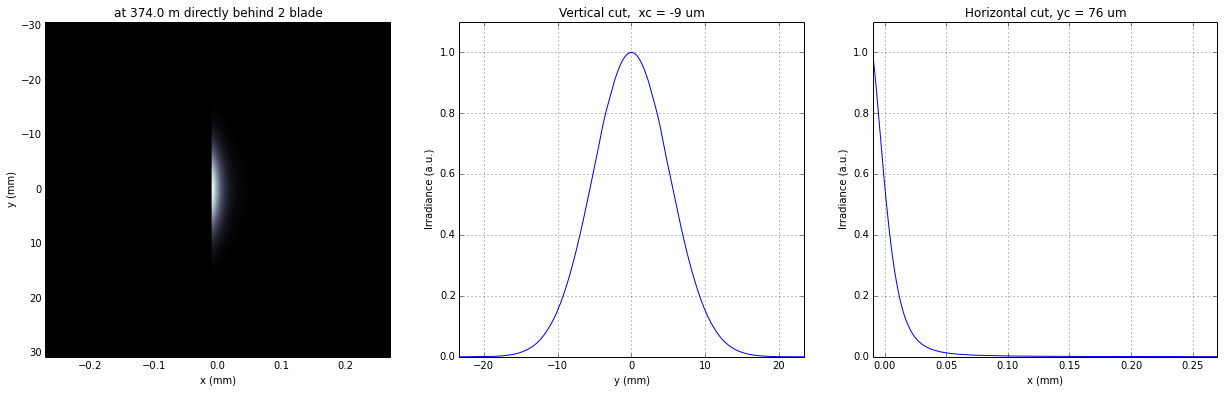

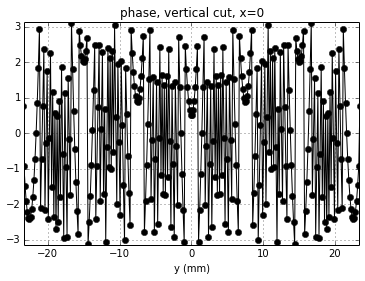

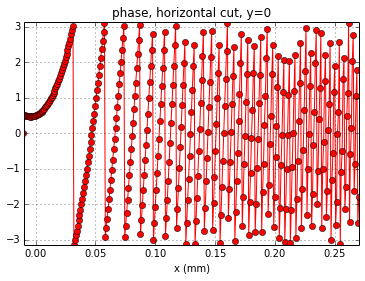

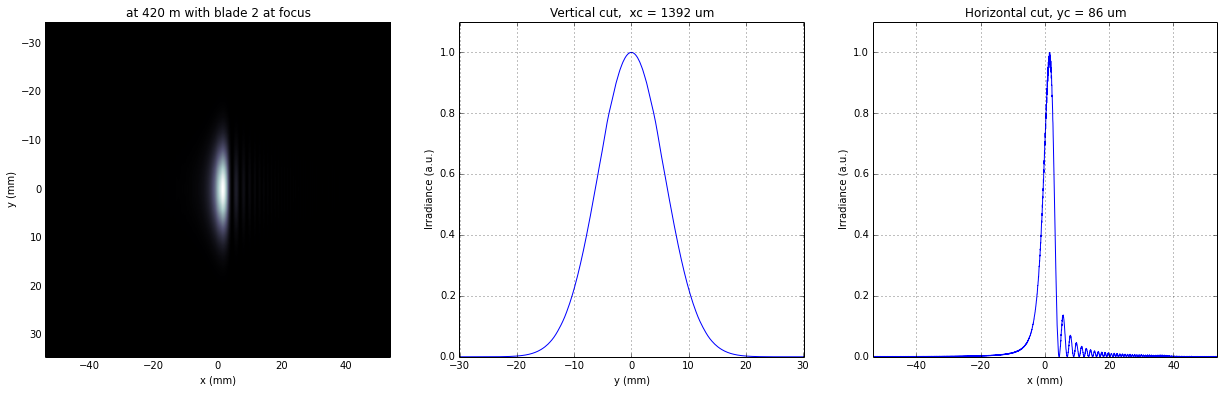

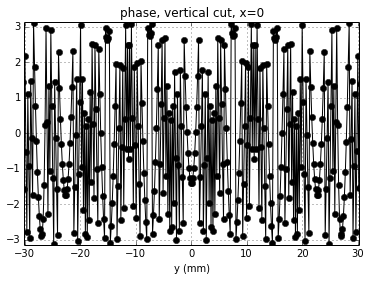

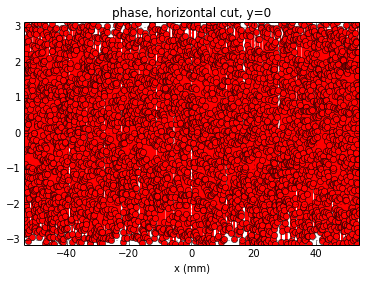

In [155]:
# reload the initial wavefront (good practise while debugging beamline)
wfr = Wavefront()
wfr.load_hdf5(wfr2Name)
print 'loading WF from %s' %wfr2Name

BL3.propagate(wfr) #propagates the beamline from 1.blade until screen

print 'Plot with obstacle'
plot_wfront(wfr, title_fig='at '+str(horFocus-0.15+distBetweenObstacles/2)+' m directly behind 2 blade', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '
BL4.propagate(wfr) #propagates the beamline from 1.blade until screen

print 'Plot with both obstacles'
plot_wfront(wfr, title_fig='at '+str(ScreenPosition)+' m with blade 2 at focus', isHlog=False, isVlog=False, 
            i_x_min=1e-4, i_y_min=1e-4, orient='x', onePlot=True, bPlotPha=True)
print ' '